In [1]:
import numpy as np
import cv2
import re
import math
from struct import *
import matplotlib.pyplot as plt

In [2]:
path_img_l = "im0.png"
path_img_r = "im1.png"

In [3]:
def plot_images(list_of_images, max_col = 4):
    n = len(list_of_images)
    if n == 1:
        plt.imshow(list_of_images[0], cmap="gray"); plt.axis('off'); plt.show()
    else:
        # get number of columns and rows required
        r, c = 1, n
        if n > max_col:
            c = max_col
            r = int(math.ceil(n/max_col))
    
        fig = plt.figure(figsize=(15, 15))
        for i, (img,name) in enumerate(list_of_images):
            ax = fig.add_subplot(r, c, (i+1))
            ax.set_title(str(name))
            ax.axis('off')
            ax.imshow(img, cmap="gray")

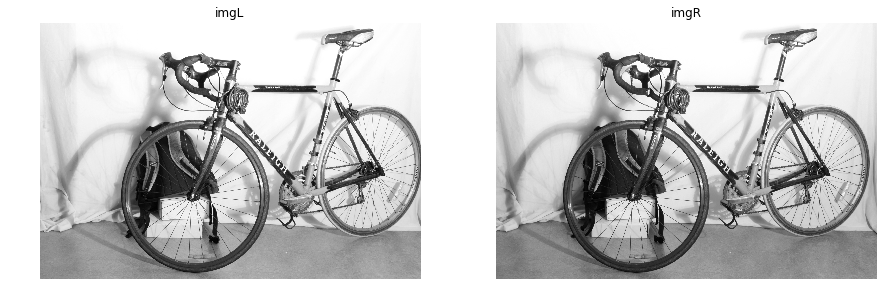

In [4]:
imgL = cv2.imread(path_img_l, cv2.IMREAD_GRAYSCALE)
imgR = cv2.imread(path_img_r, cv2.IMREAD_GRAYSCALE)
plot_images([(imgL, "imgL"), (imgR, "imgR")])

# Part A - Compute Sift Keypoints

In [5]:
def compute_sift_keypoints(imgL, imgR, thr = 0.6):
    sift = cv2.xfeatures2d.SIFT_create()
    bfMatcher = cv2.BFMatcher(cv2.NORM_L2)
    
    # find keypoints and descriptors with SIFT
    kpL, desL = sift.detectAndCompute(imgL, None)
    kpR, desR = sift.detectAndCompute(imgR, None)
    
    # match descriptors (find the best two matches for each descriptor)
    matches = bfMatcher.knnMatch(desL, desR, k=2)

    # ratio test - store the list of best matches from both images
    good, ptsL, ptsR = [], [], []
    bad, bad_ptsL, bad_ptsR = [], [], []
    for i, (m, n) in enumerate(matches):
        if m.distance < thr * n.distance:
            good.append(m)
            ptsR.append(kpR[m.trainIdx].pt)
            ptsL.append(kpL[m.queryIdx].pt)
        else:
            bad.append(m)
            bad_ptsR.append(kpR[m.trainIdx].pt)
            bad_ptsL.append(kpL[m.queryIdx].pt)

    return good, np.int32(ptsL), np.int32(ptsR), bad, np.int32(bad_ptsL), np.int32(bad_ptsR)

In [6]:
good, ptsL, ptsR, bad, bad_ptsL, bad_ptsR = compute_sift_keypoints(imgL, imgR, 0.4)

# Part B - Display Epipolar Lines

In [7]:
# Taken from ECSE 415 - tutorial 6
def drawlines(img1, img2, lines, pts1, pts2):
    row, col = img1.shape
    # convert from grayscale to BGR
    img1 = cv2.cvtColor(img1, cv2.COLOR_GRAY2BGR)
    img2 = cv2.cvtColor(img2, cv2.COLOR_GRAY2BGR)
    # for each line
    for r, pt1, pt2 in zip(lines, pts1, pts2):
        # pick a random color
        color = tuple(np.random.randint(0, 255, 3).tolist())
        x0, y0 = map(int, [0, -r[2]/r[1]])
        x1, y1 = map(int, [col, -(r[2]+r[0]*col)/r[1]])
        # draw the lines and the points
        img1 = cv2.line(img1, (x0,y0), (x1,y1), color, 1)
        img1 = cv2.circle(img1, tuple(pt1), 5, color, -1)
        img2 = cv2.circle(img2, tuple(pt2), 5, color, -1)
    return img1, img2

In [8]:
def display_ep_lines(imgL, imgR, ptsL, ptsR):
    F, mask = cv2.findFundamentalMat(ptsL, ptsR, cv2.FM_LMEDS)

    # Use only inliers for remaining computations
    ptsL = ptsL[mask.ravel()==1]
    ptsR = ptsR[mask.ravel()==1]

    # find ep lines
    linesL = cv2.computeCorrespondEpilines(ptsR, 2, F)
    linesL = linesL.reshape(-1, 3)
    # draw lines
    imgL1, imgR1 = drawlines(imgL, imgR, linesL, ptsL, ptsR)

    linesR = cv2.computeCorrespondEpilines(ptsL, 1, F)
    linesR = linesR.reshape(-1, 3)
    # draw lines
    imgR2, imgL2 = drawlines(imgR, imgL, linesR, ptsR, ptsL)
    
    
    plot_images([(imgL1, "Left Image"), (imgR1, "Right Image"), (imgL2, "Left Image"), (imgR2, "Right Image")],2)

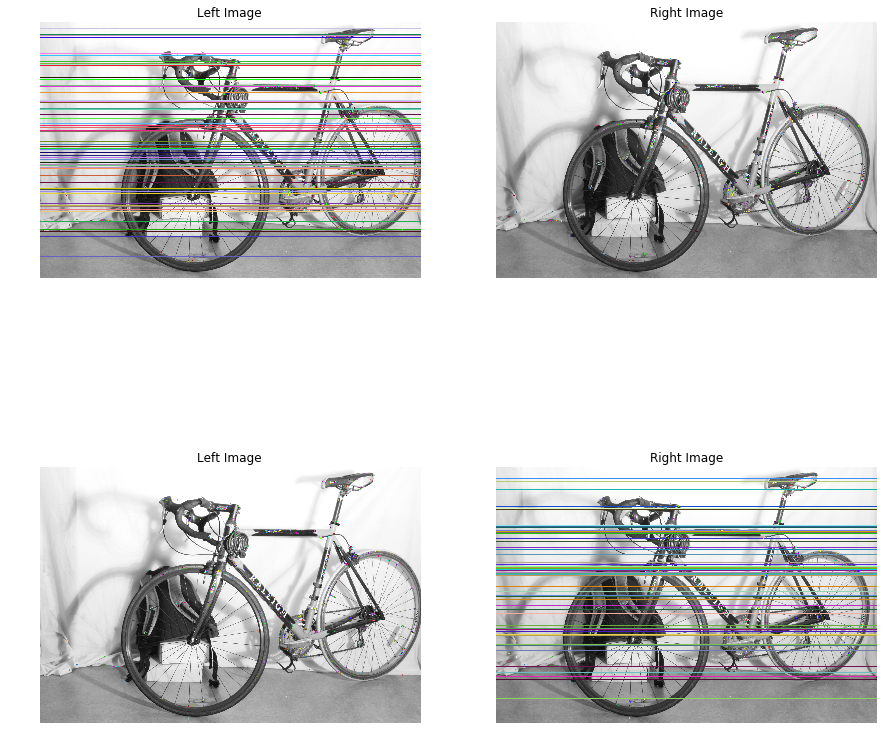

In [9]:
display_ep_lines(imgL, imgR, ptsL, ptsR)

# Part C - Pick a Bad Keypoint

In [15]:
def extract_patch(img, pt):
    x, y = pt[0], pt[1]
    x_m = x - int(5/2)
    x_n = x + 5 - int(5/2)
    y_m = y - int(5/2)
    y_n = y + 5 - int(5/2)
    return img[y_m:y_n, x_m:x_n]

In [16]:
a_bad_kpt = bad_ptsL[0]
patch = extract_patch(imgL, a_bad_kpt)

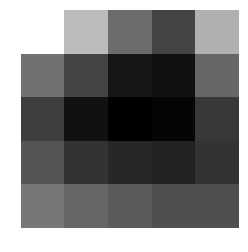

In [17]:
plot_images([patch])

# Part D - Match using SSD

In [95]:
def extract_patches_horizontal(img, pt):
    x, y = pt[0], pt[1]
    h, w = img.shape
    all_patches = []
    m = int(5/2)
    n = 5 - m
    
    # starting and ending at 2 b/c of edge
    for column in range(2,w-2):
        all_patches.append(img[y-m:y+n,column-m:column+n])

    return all_patches

def get_ssd(extracted, patches):
    
    all_ssd = []
    for p in patches:
        all_ssd.append(np.sum((p - extracted) ** 2))

    match_patch = patches[np.argmin(all_ssd)]
    return np.array(all_ssd), match_patch

In [96]:
horizontal_patches = extract_patches_horizontal(imgL, a_bad_kpt)
ssds, match_patch = get_ssd(patch, horizontal_patches)

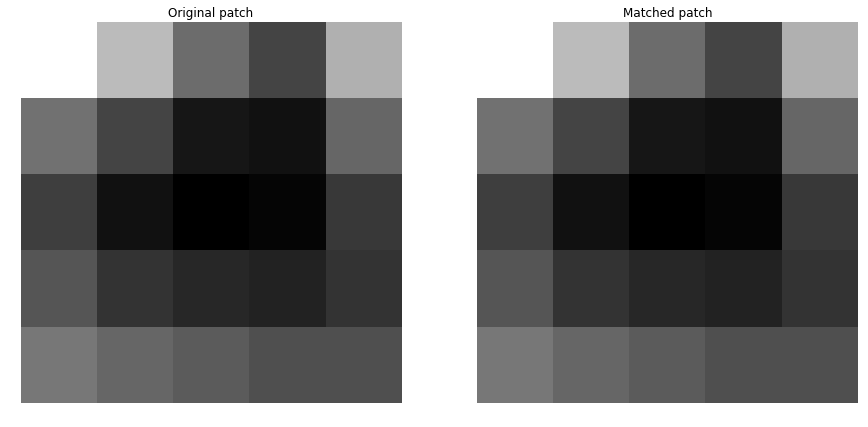

In [97]:
plot_images([(patch, "Original patch"), (match_patch, "Matched patch")])

# Part E - Plot SSD
NOT COMPLETED

# Part F - Plot SSD
NOT COMPLETED

# Part G - Plot SSD
NOT COMPLETED

# Part H - Plot SSD
NOT COMPLETED